# ASSIGNMENT:

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_A={i:f"{models_path}ref{i}.png" for i in range(1,15)}
products_B={i:f"{models_path}ref{i}.png" for i in range(15,28)}

scenes_A={i:f"{scenes_path}scene{i}.png" for i in range(1,6)}
scenes_B={i:f"{scenes_path}scene{i}.png" for i in range(6,13)}

## TRACK A

In [52]:
def denoise_image(image, filters):
    '''
    Apply denoising filters to the input image.

    Parameters:
    image (array_like): The input image to be denoised.
    filters (list of dict): A list of dictionaries, each representing a denoising filter to be applied.
        Each dictionary should have the following keys:
            - name (str): The name of the filter.
            - n_iter (int): The number of iterations to apply the filter.
            - params (dict): A dictionary containing parameters specific to the filter.

    Returns:
    array_like: The denoised image.

    Example:
    >>> denoised_image = denoise_image(input_image, [
    >>>     {"name": "mean", "n_iter": 1, "params": {"ksize": 7}},
    >>>     {"name": "median", "n_iter": 1, "params": {"ksize": 5}},
    >>>     {"name": "bilateral", "n_iter": 1, "params": {"d": 3, "sigmaColor": 2, "sigmaSpace": 1.5}},
    >>>     {"name": "gaussian", "n_iter": 1, "params": {"sigmaX": 2}},
    >>>     {"name": "non_local_means", "n_iter": 1, "params": {"templateWindowSize": 5, "searchWindowSize": 21, "h": 3, "hColor": 20}},
    >>>     {"name": "canny", "n_iter": 1, "params": {"threshold1": 5, "threshold2": 21}},
    >>>     {"name": "sharpen", "n_iter": 1, "params": {}}, # 3x3 kernel
    >>>     {"name": "emboss", "n_iter": 1, "params": {}}   # 3x3 kernel
    >>> ])
    '''
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225.0).astype('uint8')

def  normalize2(image):
    # Calculate new values through linear interpolation
    max_value = np.max(image)
    new_image = np.interp(image, (0, max_value), (0, 255)).astype('uint8')
    return new_image

def normalize3(image):
    return cv2.normalize(image, None, 0,255,cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [53]:
def diagonal(points,point2=None):
    if point2:
        return np.sqrt(np.abs((points[0]-point2[0])**2+(points[1]-point2[1])**2))
    return np.sqrt(np.abs(np.sum(np.subtract(points[:1,:],points[1:,:])**2)))

def get_geometry(corners):
    return {'position': tuple(np.round((np.sum(corners,axis=0)/4)[0],0).astype(int)),
        'width': f'{diagonal(corners[1:3,:]):0.0f}px',
        'height': f'{diagonal(corners[:2,:]):0.0f}px'
    }

### Auxiliar mehods used by the printing ones

In [54]:
def inside(center,image_shape): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if a point (the centers of the bounding boxes) is inside the scene image
    '''
    return (center[0]>=0 and center[0]<image_shape[1]) and (center[1]>=0 and center[1]<image_shape[0])


def outside(geometry,image_shape,tollerance): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if any point of the bounding box is outside of the image
    '''
    cx,cy=geometry['position']
    w=int(geometry['width'][:-2])
    h=int(geometry['height'][:-2])
    L=cx-w/2
    R=cx+w/2
    U=cy-h/2
    D=cy+h/2
    return L<=-tollerance or R>image_shape[1]+tollerance or U<=-tollerance or D>image_shape[0]+tollerance

def check_Boundings(point,geometry):
    '''
	checks wheter or not a point is inside a bounding box (computed using `get_geometry`)
    '''
    try:
        pointX,pointY=point
        centerX,centerY=geometry['position']
        sizeX=int(geometry['width'][:-2])
        sizeY=int(geometry['height'][:-2])
        return (centerX-sizeX/2<=pointX and pointX<=centerX+sizeX/2) and (centerY-sizeY/2<=pointY and pointY<=centerY+sizeY/2)
    except ValueError:
        return False
    

def reflag_single_products(results):
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product in keys:
            results[scene][product]['flag'] = True


def flag_same_products_SI(results,method='overlapping_center',method_param=50,show_concentric_texts=False):
    '''
    Single Instance:
	for every couple of products in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches
    '''
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product1 in keys:
            for product2 in [k for k in keys if k!=product1]:
                match method:
                    case 'center_vicinity':
                        if diagonal(results[scene][product1]["geometry"]["position"],results[scene][product2]["geometry"]["position"]) < method_param:
                            if show_concentric_texts:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                    case 'overlapping_center':
                        point = results[scene][product1]["geometry"]["position"] # tuple (x,y)
                        if check_Boundings(point,results[scene][product2]["geometry"]):
                            if show_concentric_texts:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                            
                    case _:
                        pass

### Printing methods

In [55]:
def display_settings(settings):
    '''
    print used filters and additional settings
    '''
    aux=[filter for filter in settings if ( 'matching_settings' in filter.keys() or filter['n_iter']>0)]
    display(aux)

### RESULTS

### Draw bounding boxes:

In [56]:
def get_angles(geometry_dict):
    '''
    return the angles with shape (4,1,2)
    '''
    center_x, center_y = geometry_dict['position']
    width = int(geometry_dict['width'][:-2])
    height = int(geometry_dict['height'][:-2])
    
    top_left = np.array([center_x - width/2, center_y + height/2])
    bottom_left = np.array([center_x - width/2, center_y - height/2])
    bottom_right = np.array([center_x + width/2, center_y - height/2])
    top_right = np.array([center_x + width/2, center_y + height/2])
    corners = np.array([top_left, bottom_left, bottom_right, top_right]).reshape(4, 1, 2)
    
    return corners


## TRACK B

In [57]:
# sift_settings={
#     'nOctaveLayers':8,
#     'contrastThreshold':0.03,
#     'sigma':1.3,
# }

In [58]:
sift_settings={
    'nOctaveLayers':12,
    'contrastThreshold':0.03,
    'sigma':1.1,
}

In [59]:
products_info_B = {}
read_products_B={}
SHOW_KEYPOINTS=False
if SHOW_KEYPOINTS:
    fig, axes = plt.subplots(3, 5, figsize=(14, 20))
    axes = axes.flatten()
sift=None
for i, product in enumerate(products_B):
    image = cv2.imread(products_B[product])
    read_products_B[product]=image
    sift = cv2.SIFT_create(**sift_settings)
    keypoints = sift.detect(image)
    products_info_B[product]=(list(sift.compute(image, keypoints))+[image.shape[:-1]])
    if SHOW_KEYPOINTS:
        img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(products_B[product][len(models_path):])
        if i==len(products_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS:

    plt.tight_layout()
    plt.show()

In [60]:
def get_baricenter(points):
    return np.mean([p.pt for p in points],axis=0)

def joining(p,b):
    return b-p

def create_star_models(products):
    '''
	products
        -k, d, s
    '''
    for product in products:
        kps=products[product][0]
        barycenter=get_baricenter(kps)
        V=[]
        for k in kps:
            V.append(joining(k.pt,barycenter))
        products[product].append(tuple(V))
        # print(barycenter,V[-1],kps[-1].pt)
    return products

products_info_B=create_star_models(products_info_B)

In [61]:
def remove_duplicate_KPs(old_keypoints, new_keypoints, tol=3):
    for k in old_keypoints:
        for nk in new_keypoints:
            if nk.pt[0] < k.pt[0] + tol and nk.pt[0] > k.pt[0] - tol and nk.pt[1] < k.pt[1] + tol and nk.pt[1] > k.pt[1] - tol:
                new_keypoints.remove(nk)
    return new_keypoints

settings_B = [[
        {'name': "median",
            "n_iter": 2,
            "params": {"ksize": 3}
         },
        {'name': "median",
            "n_iter": 0,
            "params": {"ksize": 5}
         },
        {'name': "median",
            "n_iter": 1,
            "params": {"ksize": 7}
         },
    ],
    # [{'name': "median",
    #         "n_iter": 0,
    #         "params": {"ksize": 3}
    #     },
    #     {'name': "median",
    #         "n_iter": 4,
    #         "params": {"ksize": 5}
    #     },
    #     {'name': "median",
    #         "n_iter": 0,
    #         "params": {"ksize": 7}
    #     },
    # ]
]

SHOW_KEYPOINTS = False
SHOW_FILTERED = False

if SHOW_KEYPOINTS or SHOW_FILTERED:
    fig, axes = plt.subplots(3, 3, figsize=(24, 20))
    axes = axes.flatten()

scene_info_B = {}
read_scenes_B={}
for i, scene in enumerate(scenes_B):
    image = cv2.imread(scenes_B[scene])
    sift = cv2.SIFT_create(**sift_settings)
    keypoints = []
    for settings in settings_B:
        filtered_image = denoise_image(image, settings)
        filtered_image = normalize2(filtered_image)
        if keypoints!=[]:
            keypoints.extend(remove_duplicate_KPs(keypoints, list(sift.detect(filtered_image))))
        else:
            keypoints = list(sift.detect(filtered_image))
        print(f'{i+6}:{len(keypoints)}')
    keypoints = tuple(keypoints)
    read_scenes_B[scene]=filtered_image
    scene_info_B[scene]=list(sift.compute(filtered_image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS or SHOW_FILTERED:
        printable_image = image
        if SHOW_FILTERED:
            printable_image = filtered_image
        if SHOW_KEYPOINTS:
            printable_image = cv2.drawKeypoints(
                filtered_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(printable_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(scenes_B[scene][len(scenes_path):])
        # remove unused subplots
        if i == len(scenes_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS or SHOW_FILTERED:
    plt.tight_layout()
    plt.show()


6:26540
7:15819
8:24946
9:16169
10:27318
11:18819
12:17305


In [62]:
def remove_used_KP_DES(keypoints,descriptors,angles):
    '''
	removes the keypoint, and the relative descriptor, already used.
    To do so we check if the keypoint is inside the polygon found in the homography,
    meaning that all the points inside the product that has been found are removed.

    The method used is called ray-casting: given a point if the number of crossing of the polygon
    border is odd then we are inside.
    '''
    if angles.size == 0:
        return keypoints,descriptors
    removed=0
    keypoints = list(keypoints)
    angles=[tuple(row[0]) for row in angles]
    for ikp in range(len(keypoints)):
        px, py = keypoints[ikp-removed].pt
        count = 0
        n = len(angles) # this is always 4 in our case
        remove=False
        for i in range(n):
            x1, y1 = angles[i]
            x2, y2 = angles[(i + 1) % n]

            # Check if the point is exactly on a vertex
            if (px, py) == (x1, y1) or (px, py) == (x2, y2):
                remove= True

            # Check if the point is on the edge
            if y1 != y2 and min(y1, y2) <= py <= max(y1, y2):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px == x_intercept:
                    remove= True

            # Check intersections with a ray from the point
            if (y1 <= py < y2) or (y2 <= py < y1):
                x_intercept = (py - y1) * (x2 - x1) / (y2 - y1) + x1
                if px < x_intercept:
                    count += 1

        if count % 2 == 1 or remove:
            keypoints.pop(ikp-removed)
            descriptors = np.delete(descriptors, ikp-removed, 0)
            removed += 1
    return tuple(keypoints), descriptors

In [63]:
# possibilities: HISTCMP_CORREL, HISTCMP_CHISQR, HISTCMP_INTERSECT, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR_ALT, HISTCMP_KL_DIV
def get_histogram_score(product, scene, scene_geometry, method = cv2.HISTCMP_INTERSECT):
    PLOT = False
    # if we want to use an higher number of bins (possibly up to 256(0, 255) it won't be possible to use HISTCMP_CORREL as metric
    # with the images we're using, since they're quite big and the compare method will return nan
    hist_sizes = [16, 16, 16]  
    ranges = [0, 256, 0, 256, 0, 256]
    product_image = read_products_B[product-1-len(products_A)]
    scene_image = read_scenes_B[scene-1-len(scenes_A)]
    scene_corners = get_angles(scene_geometry)
    
    # Slicing images where product is found
    row_min = min(max(int(min(a[0][1] for a in scene_corners)), 0), scene_image.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in scene_corners)), scene_image.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in scene_corners)), 0), scene_image.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in scene_corners)), scene_image.shape[1]-1),0)
    scene_image = scene_image[row_min:row_max, col_min:col_max]
    
    # Computing histograms
    product_hists = cv2.calcHist([product_image], [0,1,2], None, hist_sizes, ranges)
    scene_hists = cv2.calcHist([scene_image], [0,1,2], None, hist_sizes, ranges)
        
    title = f'(x,y):{scene_geometry["position"]}, dim:{scene_geometry["width"]} x {scene_geometry["height"]}\n'
    for i in range(6):    
        title += f'{i}: {cv2.compareHist(product_hists, scene_hists, i):.2f} '
    if PLOT:
        fig = plt.figure(figsize=(20,5))
        fig.suptitle(title)
        plt.subplot(2,2,1)
        plt.imshow(cv2.cvtColor(product_image,cv2.COLOR_BGR2RGB))
        plt.subplot(2,2,2)
        plt.imshow(cv2.cvtColor(scene_image,cv2.COLOR_BGR2RGB))
        plt.subplot(2,2,3)
        chans = cv2.split(product_image)
        colors = ("b", "g", "r")
        # loop over the image channels
        for (chan, color) in zip(chans, colors):
            # create a histogram for the current channel and plot it
            hist = cv2.calcHist([chan], [0], None, [hist_sizes[0]], ranges[0:2])
            plt.plot(hist, color=color)
            plt.yscale('log')
            plt.grid()
            
        #Same for scenes
        plt.subplot(2,2,4)
        chans = cv2.split(scene_image)
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [hist_sizes[0]], ranges[0:2])
            plt.plot(hist, color=color)
            plt.yscale('log')
            plt.grid()

    # Normalize the histograms
    # cv2.normalize(product_hists, product_hists)
    # cv2.normalize(scene_hists, scene_hists)

    # Compare the histograms
    score = cv2.compareHist(product_hists, scene_hists, method)
    
    return score

In [100]:
def create_accumulator(shape,target_kp,template_kp,joining_vectors,rotation_bins=36,scale_bins=0):
    print(shape,len(target_kp),len(template_kp))
    a=np.array([aa.size for aa in target_kp])
    b=np.array([bb.size for bb in template_kp])
    r=np.unique(np.round(a/b,decimals=1))
    print(a,b,r,r.shape)
    # accumulator=np.zeros((*shape[:2],))

In [101]:
# resulting matches/positions will be stored here
results_B = {}
MIN_NUM_MATCHES = 5

for i, scene in enumerate(scene_info_B, 6): #the index is used to store the correct scene number on the resulting dict
    if i not in (6,9, 12): # TODO da togliere
        continue
        pass
    results_B[i] = {}
    for j, product in enumerate(products_info_B, 15): # same as earlier enumerate, but for the products
        if j not in (15,): # TODO da togliere
            continue
            pass
        results_B[i][j]=[]

        
        kp_scene, des_scene=scene_info_B[scene][:2].copy() # the last element is the shape, we dont need it at the moment
        kp_prod, des_prod = products_info_B[product][:2].copy()
        V_prod=products_info_B[product][3]
        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(des_prod, des_scene, k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.8*n.distance:
                good.append(m)

        # dst=np.array([])
        # old_des_number = 0
        # we keep looking for products untill:
        # a) there are no descriptors/keypoints
        # b) we have found an homography that did not remove any point -> it was not an actual product but an artifact
        # c) there are not enough(4) points for an homography
        try:
            matches = matcher.knnMatch(products_info_B[product][1],des_scene,k=2)
            good = []
            for m,n in matches:
                if m.distance < 0.8*n.distance:
                    good.append(m)
            
            src_kp = [kp_prod[m.queryIdx] for m in good]
            # src_des = [des_prod[m.queryIdx].pt for m in good]
            src_V = [V_prod[m.queryIdx] for m in good]
            dst_kp = [kp_scene[m.trainIdx] for m in good]
            
            if len(src_kp)<4: # c)
                break
            
            
            accumulator=create_accumulator(shape=scene_info_B[scene][2],
                                           target_kp=dst_kp,
                                           template_kp=src_kp,
                                           joining_vectors=src_V,
                                        ) #  TODO
            found_maxima=find_accumulator_maxima(accumulator)

            for point,maxima_value in found_maxima:
                g=extract_geometry(point,scale,template_des) #  TODO create the ROI knowing the center of the template the size and its shape
                results_B[i][j].append({
                    'match_count': int(maxima_value),
                    'geometry': g,
                    'flag':True,
                    'score': get_histogram_score(product=j, scene=i, scene_geometry=g, method=cv2.HISTCMP_INTERSECT)
                    }
                )
        except cv2.error as e:
            print(f'{repr(e)}')

(1072, 1514, 3) 421 421
[ 1.56716025  1.43726945 14.51076794  1.58514607  6.70752096 15.30434418
 15.30434418  1.51636648  1.57949734  1.53856397  1.64261782 11.75677013
  1.60907769 24.89287758  1.77239811  1.81802785  8.44266605  1.65993035
 22.43679237  1.56716025  1.47899532  1.51991808  1.71562481  1.56716025
  1.56716025  1.56716025  2.12822366  1.56716025  1.56716025 26.55446815
 12.25550842  1.69450939  1.71013784 12.6002655   1.71562481  1.56716025
  1.51068401  1.54510009  1.56716025 24.48711205 24.48711205 12.58726978
  1.71562481  1.56716025  1.56716025  1.56716025  1.56716025  1.60186589
  1.69118452 14.76674843  1.67803884  1.58126605  1.66145706  1.68953753
  1.56716025 10.76642799  7.14052629  7.14052629  6.66700125 14.10916519
  6.40307713  1.56716025 14.10916519  1.56716025  1.56716025 26.80154037
 26.80154037  1.54163659  1.63737929 13.01021385 31.76087189 17.77436638
  1.59772432  2.12822366  1.56716025  1.55730247  1.56716025 11.12628174
  1.56716025  1.71562481 14

NameError: name 'find_accumulator_maxima' is not defined

### Auxiliar mehods used by the printing ones

In [ ]:
def flag_same_products_MI(results,method='overlapping_center', show_concentric_texts = False):
    '''
    Multiple Instance:
	for every couple of instances in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches.

      method='overlapping_center'means that we search for bounding boxes whith
      center inside another bounding box, if so only keep the one with the most 
      number of matches
    '''
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product1 in keys:
            for product2 in keys:
                for instance1 in range(len(results[scene][product1])):
                    if not results[scene][product1][instance1]["flag"]: # if products are already flagged, do not compute them
                        continue
                    for instance2 in range(len(results[scene][product2])):
                        if not results[scene][product2][instance2]["flag"]: # if products are already flagged, do not compute them
                            continue
                        if product1==product2 and instance1==instance2: # if we check a product with himself
                            continue
                        match method:
                            case 'histogram_comparing':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    score1 = results[scene][product1][instance1]["score"]
                                    score2 = results[scene][product2][instance2]["score"]
                                    if show_concentric_texts:
                                        print(f'{scene}: {product1, point} and {product2,results[scene][product2][instance2]["geometry"]["position"]} concentric:\n1:{score1} - 2: , {score2}')
                                    #if score1 > score2:
                                    if np.abs(score1) > np.abs(score2):
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                            case _:pass
                                

def reflag_multiple_products(results):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                results[scene][product][instance]['flag'] = True


def delete_outside_bounding_boxes_MI(results, tollerance):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                if outside(results[scene][product][instance]['geometry'],scene_info_B[scene-len(scenes_A)-1][2],tollerance):
                    results[scene][product][instance]['flag'] = False


def delete_small_bounding_boxes_MI(results,treshold):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                w=int(results[scene][product][instance]['geometry']['width'][:-2])
                h=int(results[scene][product][instance]['geometry']['height'][:-2])
                if w*h<treshold:
                    results[scene][product][instance]['flag'] = False
    

### Print methods

In [ ]:
def print_multiple_instances(results: dict,min_match,check_pos,return_dict=False):
    max_product_len = max(len(str(product)) for scene in results for product in results[scene])
    max_instance_len = max(len(str(len(results[scene][product]))) for scene in results for product in results[scene])
    max_match_len = max(len(str(product["match_count"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_x_len = max(len(str(product["geometry"]["position"][0])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scene_info_B[scene-1][2]))
    max_y_len = max(len(str(product["geometry"]["position"][1])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scene_info_B[scene-1][2]))
    max_width_len = max(len(str(product["geometry"]["width"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_height_len = max(len(str(product["geometry"]["height"])) for scene in results for products in results[scene] for product in results[scene][products])

    if return_dict:
        results_dict={}

    for i,scene in enumerate(results):
        if return_dict:
            results_dict[scene]={}
        print(f'Scene {scene}:')
        for products in results[scene]:
            printable_prods=[]
            for product in results[scene][products]:
                if (product['match_count'] >= min_match and 
                    product['flag'] and 
                    (
                        (not check_pos) or 
                        inside(product['geometry']['position'], scene_info_B[scene-len(scenes_A)-1][2])
                    )):
                    printable_prods.append(product)
            num_inside=len(printable_prods)
            if num_inside>0:
                if return_dict:
                    results_dict[scene][products]=[]
                print(f"\tProduct {products:<{max_product_len}} - {num_inside} instance found:")
                printable_prods = sorted(printable_prods, key=lambda instance: instance['geometry']["position"][0])
                for i,product in enumerate(printable_prods,1):
                    if return_dict:
                        results_dict[scene][products].append(product)
                    print(
                    f"\t\tInstance {str(i)+',':<{max_instance_len+1}}"
                    + f" matches: {str(product['match_count'])+',':<{max_match_len+1}}"
                    + f" score: {product['score']:.3f}"
                    + f" {{position: ({str(product['geometry']['position'][0])+',':<{max_x_len}}"
                    + f" {str(product['geometry']['position'][1])+'),':<{max_y_len}}"
                    + f" width: {str(product['geometry']['width'])+',':<{max_width_len}}"
                    + f" height: {product['geometry']['height']:<{max_height_len-1}}}}"
                    )
    if return_dict:
        return results_dict

In [ ]:
MIN_MATCH_COUNT = 0
CHECK_CENTER_POSITION = False
CHECK_METHOD='histogram_comparing' # 'center_vicinity' or 'overlapping_center' or color_similarity or keypoints_colors_similarity or histogram_comparing
MIN_CENTER_DISTANCE=50
EXCEEDING_TOLLERANCE=0
MIN_AREA=50_000
# if 'matching_settings' in settings_B[-1]:
#     settings_B[-1]={'matching_settings':{'min_match':MIN_MATCH_COUNT,
#                   'check_position':CHECK_METHOD if CHECK_CENTER_POSITION else CHECK_CENTER_POSITION}}
# else:
#     settings_B.append({'matching_settings':{'min_match':MIN_MATCH_COUNT,
#                      'check_position':CHECK_METHOD if CHECK_CENTER_POSITION else CHECK_CENTER_POSITION}})
            
print('Denoise settings:')
# display_settings(settings_B)
reflag_multiple_products(results_B)
# delete_outside_bounding_boxes_MI(results_B,tollerance=EXCEEDING_TOLLERANCE)
# delete_small_bounding_boxes_MI(results_B,treshold=MIN_AREA)
# flag_same_products_MI(results_B, method=CHECK_METHOD,show_concentric_texts=False)
products_found_B=print_multiple_instances(results_B,MIN_MATCH_COUNT,CHECK_CENTER_POSITION,True)

Denoise settings:
Scene 9:
	Product 15 - 3 instance found:
		Instance 1, matches: 5,  score: 0.000 {position: (-1282, 1216), width: 9862px, height: 361px }
		Instance 2, matches: 5,  score: 0.000 {position: (728,  841), width: 1738px, height: 228px }
		Instance 3, matches: 5,  score: 0.000 {position: (728,  841), width: 1738px, height: 228px }
	Product 16 - 1 instance found:
		Instance 1, matches: 8,  score: 4.000 {position: (846,  272), width: 2px,    height: 2px   }
	Product 17 - 2 instance found:
		Instance 1, matches: 4,  score: 105946.000 {position: (1714, -714), width: 3898px, height: 3712px}
		Instance 2, matches: 4,  score: 105946.000 {position: (1714, -714), width: 3898px, height: 3712px}
	Product 19 - 4 instance found:
		Instance 1, matches: 27, score: 57460.000 {position: (616,  379), width: 231px,  height: 564px }
		Instance 2, matches: 20, score: 44460.000 {position: (844,  374), width: 224px,  height: 592px }
		Instance 3, matches: 5,  score: 3302.000 {position: (1094, 22

### Draw bounding boxes:

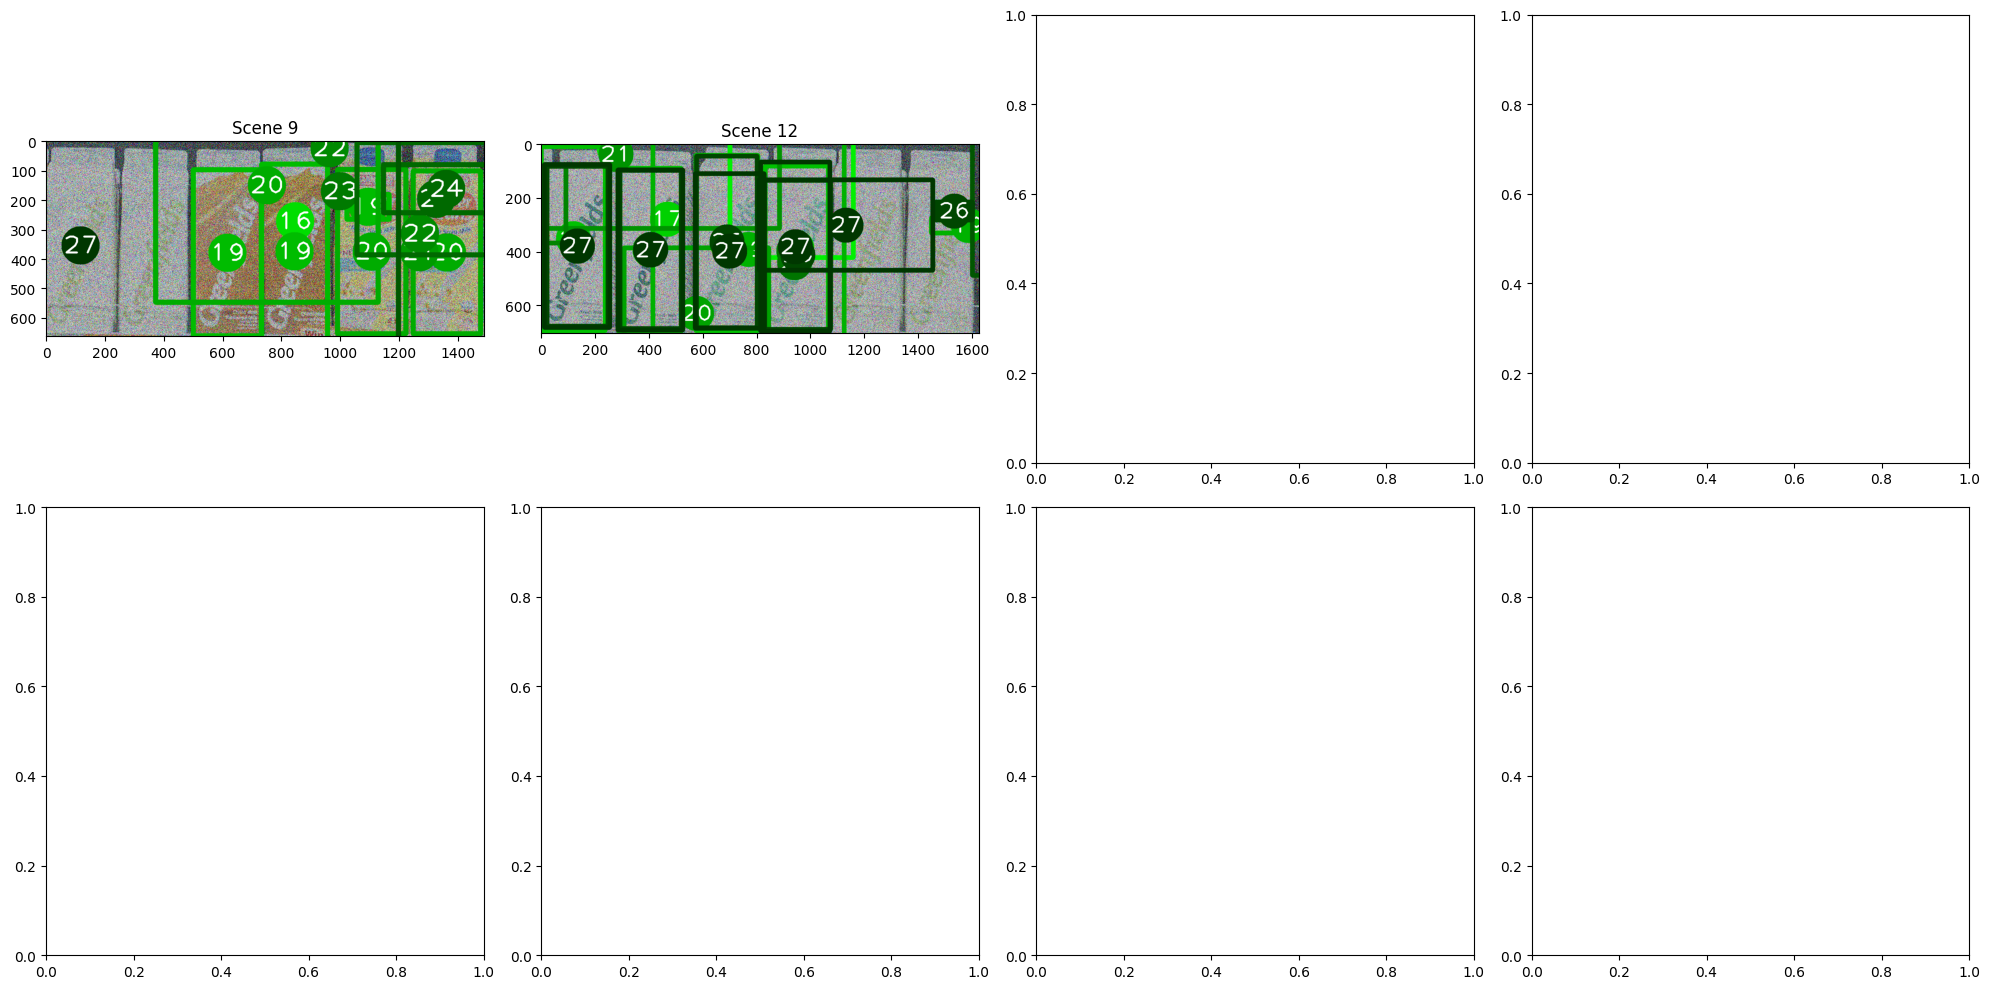

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
COLOR_RANGE=200
DRAW_CIRCLES=True
for i, scene in enumerate((products_found_B)):
    image = cv2.cvtColor(cv2.imread(scenes_B[(i+1)*3]), cv2.COLOR_BGR2RGB)
    prods=len(products_found_B[scene].keys())
    for c,products in enumerate(products_found_B[scene]):
        for instance in products_found_B[scene][products]:
            points = get_angles(instance['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            # color=[np.random.randint(0,255) for _ in range(3)]
            image = cv2.polylines(image, [np.int32(points)], True, color, 15, cv2.LINE_AA)
            text=f'{products}'
            px,py=instance['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),65,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=60
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,5)
    axes[i].imshow(image)
    # axes[i].axis('off')
    axes[i].set_title(f'Scene {scene}')
    if i == len(scenes_B)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
l=len(scene_info_B[0][0])
print(
    len(np.unique([scene_info_B[0][0][i].pt for i in range(l)])),
    len(np.unique([int(scene_info_B[0][0][i].angle) for i in range(l)])),
    len(np.unique([int(scene_info_B[0][0][i].size) for i in range(l)])),
    len(np.unique([int(scene_info_B[0][0][i].octave) for i in range(l)])),
    len(np.unique([np.round(scene_info_B[0][0][i].response,decimals=4) for i in range(l)])),
)

10825 360 77 1957 480


In [ ]:
l=len(scene_info_B[0][0])
print(
    len(np.unique([scene_info_B[0][0][i].pt for i in range(l)])),
    len(np.unique([int(scene_info_B[0][0][i].angle) for i in range(l)])),
    np.unique([int(scene_info_B[0][0][i].size) for i in range(l)]),
    len(np.unique([int(scene_info_B[0][0][i].octave) for i in range(l)])),
    len(np.unique([np.round(scene_info_B[0][0][i].response,decimals=4) for i in range(l)])),
)

10825 360 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  38  39  40  41  42  43  44  45  46  49  50  51  52  53  54  55  56  57
  60  61  63  70  71  74  76  79  82  83  86  92  93  94  97  99 101 109
 117 130 131 142 158] 1957 480


scene6:15,15  
scene7:16,16  
scene8: 27,23,23,24  
scene9:18,18,19,19,20,20  
scene10:21,21,22,22  
scene11:23,23,24,24,25,25,(27)  
scene12:26,26,27,27,18,18